# Dataset Description

## Satellite Images of Water Bodies
A collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water and black represents something else but water. The masks were generated by calculating the NWDI (Normalized Water Difference Index) which is frequently used to detect and measure vegetation in satellite images, but a greater threshold was used to detect water bodies.

#### Sentinel-2 Satellite Images:
Sentinel-2 is a satellite mission developed by the European Space Agency (ESA) as part of the Copernicus Programme. It is equipped with a multispectral imaging instrument that captures images of the Earth's surface across various spectral bands. These images are valuable for monitoring changes in the environment, including land cover, vegetation health, and water bodies.
#### Black and White Masks:
Each image in the  dataset is accompanied by a black and white mask. These masks serve as annotations or labels for the images, indicating the presence or absence of water bodies. In the masks, pixels that represent water are typically assigned a white color, while pixels representing non-water areas (such as land or built-up areas) are assigned a black color.
#### Normalized Water Difference Index (NWDI):
The NWDI is a spectral index commonly used in remote sensing to detect the presence of water in satellite images. It is calculated based on the differences in reflectance values between two specific spectral bands, typically near-infrared (NIR) and shortwave infrared (SWIR) bands. By comparing the reflectance values of these bands, the NWDI can highlight areas where water absorption features are present, allowing for the detection and delineation of water bodies in the images.
#### Thresholding for Water Detection:
In this dataset, a greater threshold than usual has been applied to the NWDI values to detect water bodies. This means that the threshold for classifying pixels as water or non-water has been set higher than the standard threshold used for vegetation detection. Adjusting the threshold allows for more accurate identification of water bodies while potentially reducing false positives or misclassifications.

Link : https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies/data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Important Libraries

In [28]:
!pip install rasterio
import rasterio

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

### Image Directory

In [31]:
image_dir = '/content/drive/MyDrive/APDS/Project/Satellite-Based-Water-Body-Segmentation-Using-CNNs/Water Bodies Dataset/Images'
mask_dir = '/content/drive/MyDrive/APDS/Project/Satellite-Based-Water-Body-Segmentation-Using-CNNs/Water Bodies Dataset/Masks'

In [33]:

def list_all_image_ids():
    image_ids = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_id = filename.split('.')[0]
            image_ids.append(image_id)
    return image_ids

def load_data(image_id):
    image_path = f"{image_dir}/{image_id}.jpg"
    image = Image.open(image_path).convert('RGB')
    image = image.resize((64, 64))
    image = np.array(image) / 255.0

    mask_path = f"{mask_dir}/{image_id}.jpg"
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((64, 64))
    mask = np.array(mask) / 255.0

    return image, mask

all_image_ids = list_all_image_ids()

images = []
masks = []

for image_id in all_image_ids:
    image, mask = load_data(image_id)
    images.append(image)
    masks.append(mask)

In [34]:
len(images)

2841

In [35]:
len(masks)

2841

### Plot Images

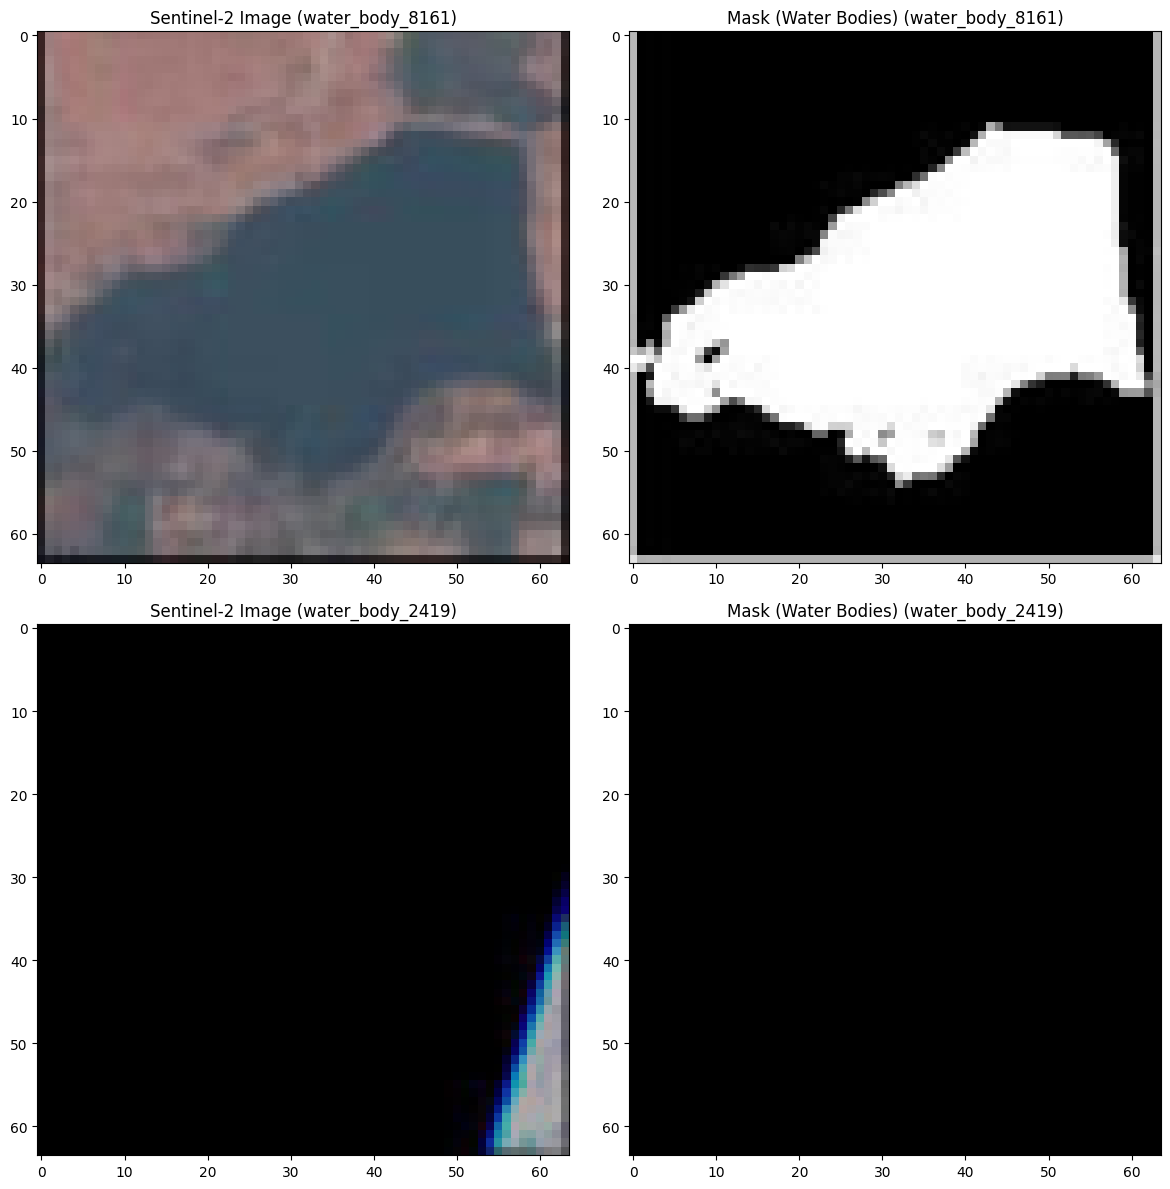

In [36]:
num_random_images = 2
random_image_ids = random.sample(all_image_ids, num_random_images)

fig, axes = plt.subplots(num_random_images, 2, figsize=(12, 6*num_random_images))

for i, image_id in enumerate(random_image_ids):
    image, mask = load_data(image_id)
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f'Sentinel-2 Image ({image_id})')
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Mask (Water Bodies) ({image_id})')

plt.tight_layout()

In [37]:
# Convert lists to NumPy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Add a channel dimension to masks
masks = masks[..., np.newaxis]

# Verify the shapes
print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')

Images shape: (2841, 64, 64, 3)
Masks shape: (2841, 64, 64, 1)


In [38]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [39]:
X_train.shape

(2272, 64, 64, 3)

This model is a simple convolutional neural network for image segmentation. It follows an encoder-decoder structure:

#### Encoder:
The first part consists of several convolutional layers followed by max pooling layers, which progressively reduce the spatial dimensions and increase the number of feature maps. This part extracts and compresses the features.

#### Decoder:
The second part consists of several upsampling layers followed by convolutional layers, which progressively increase the spatial dimensions back to the original size while refining the feature maps to produce the final segmentation mask.

In [40]:
# Build a simple CNN model
def build_model(input_shape):
    inputs = Input(input_shape)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    u1 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u3 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (64, 64, 3)
model = build_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/20
142/142 [==============================] - 130s 897ms/step - loss: 0.5322 - accuracy: 0.6004 - val_loss: 0.4525 - val_accuracy: 0.6575
Epoch 2/20
142/142 [==============================] - 130s 914ms/step - loss: 0.4405 - accuracy: 0.6623 - val_loss: 0.4096 - val_accuracy: 0.6800
Epoch 3/20
142/142 [==============================] - 131s 920ms/step - loss: 0.3977 - accuracy: 0.6832 - val_loss: 0.4210 - val_accuracy: 0.6753
Epoch 4/20
142/142 [==============================] - 122s 861ms/step - loss: 0.3788 - accuracy: 0.6922 - val_loss: 0.3750 - val_accuracy: 0.6934
Epoch 5/20
142/142 [==============================] - 127s 893ms/step - loss: 0.3659 - accuracy: 0.6979 - val_loss: 0.3673 - val_accuracy: 0.6988
Epoch 6/20
142/142 [==============================] - 122s 856ms/step - loss: 0.3490 - accuracy: 0.7045 - val_loss: 0.3542 - val_accuracy: 0.7051
Epoch 7/20
142/142 [==============================] - 127s 897ms/step - loss: 0.3523 - accuracy: 0.7035 - val_loss: 0.3638 -

18/18 [==============================] - 18s 999ms/step - loss: 0.3325 - accuracy: 0.7207
Validation Loss: 0.3325
Validation Accuracy: 0.7207
18/18 [==============================] - 9s 453ms/step


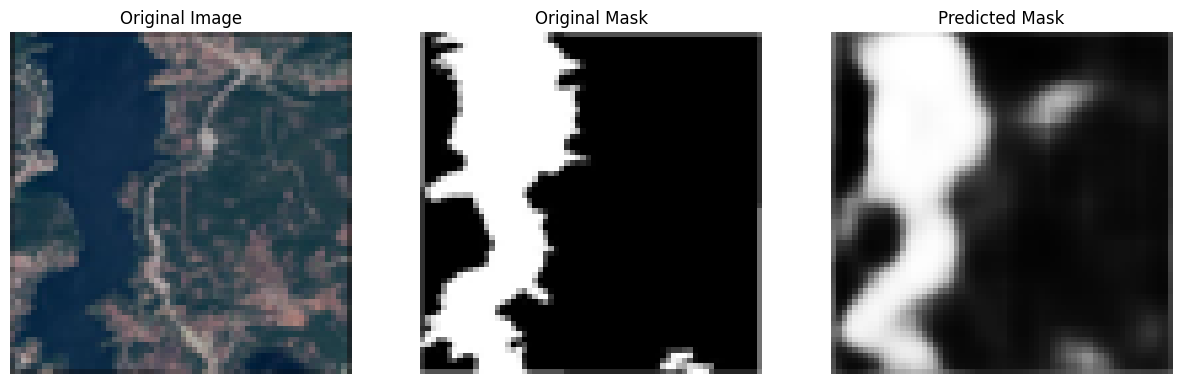

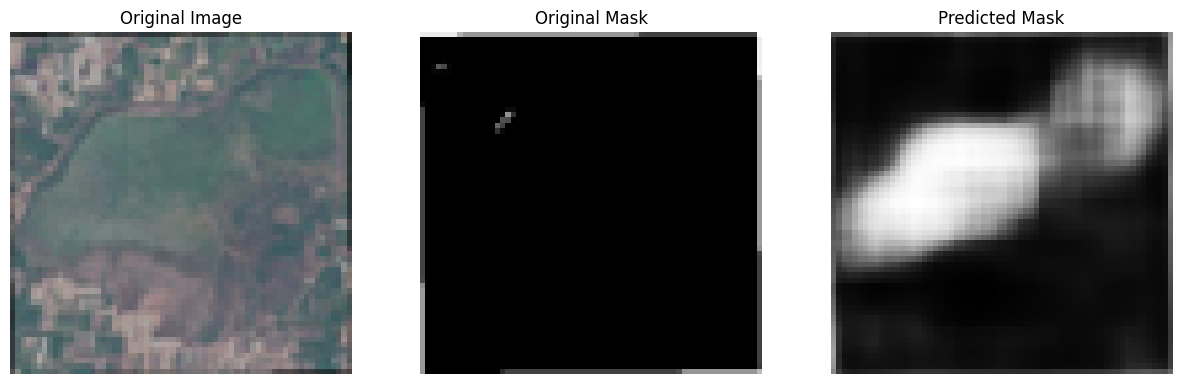

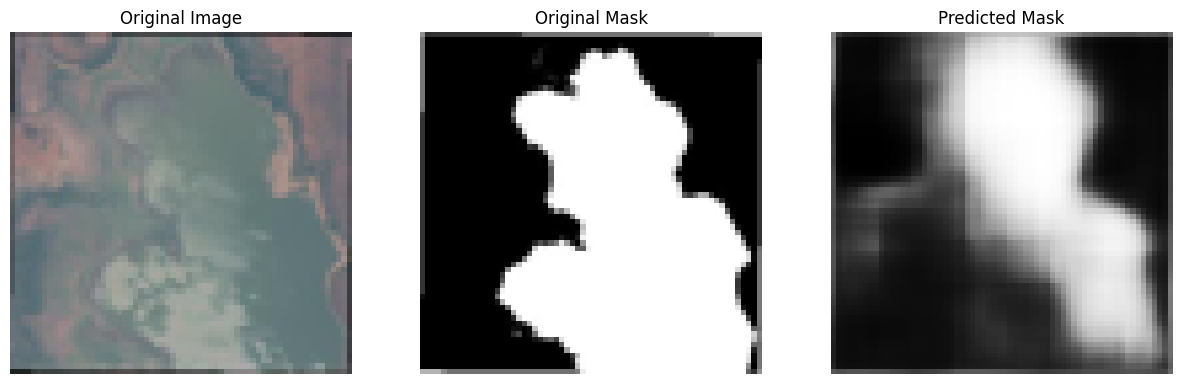

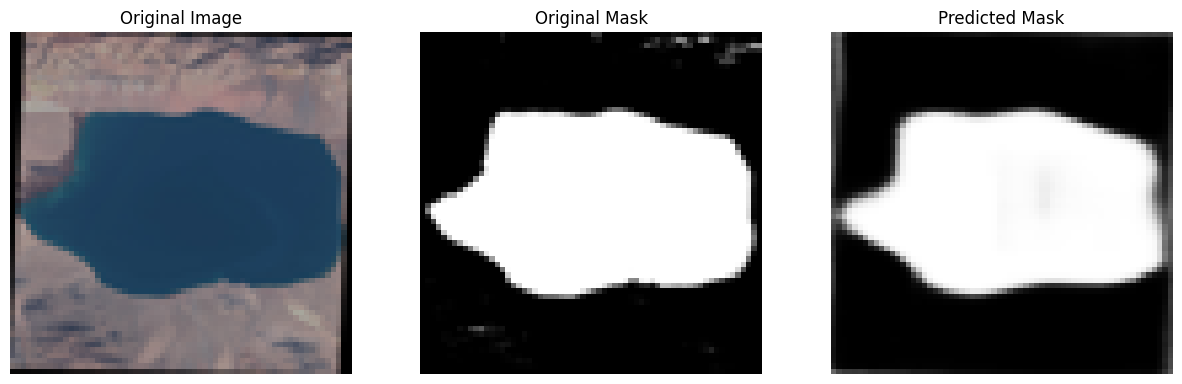

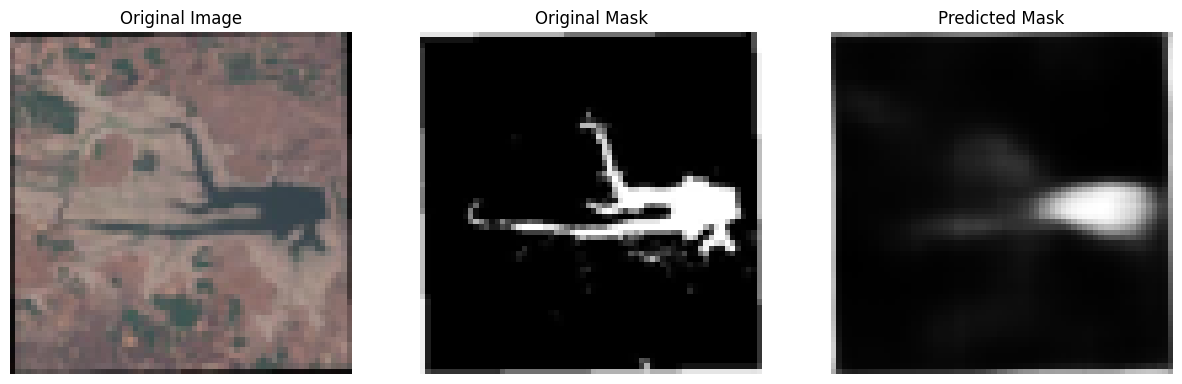

In [41]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict masks for the validation data
predicted_masks = model.predict(X_val)

# Visualize original and predicted masks for a few samples
import matplotlib.pyplot as plt

num_samples_to_visualize = 5
indices_to_visualize = np.random.choice(len(X_val), num_samples_to_visualize, replace=False)

for i in indices_to_visualize:
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title('Original Image')
    plt.axis('off')

    # Original mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(y_val[i]), cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_masks[i]), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()